In [1]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

/Users/tinyzqh/miniforge3/lib/python3.9/site-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1` with the environment ID `CartPole-v1`.
  logger.warn(


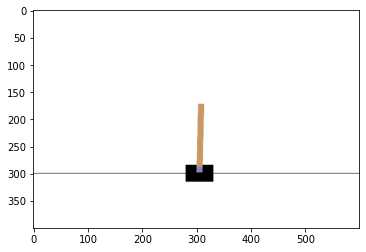

In [2]:
env = gym.make("CartPole-v0")
env.reset()

n_actions = env.action_space.n
state_dim = env.observation_space.shape
plt.imshow(env.render("rgb_array"))

## 定义一个智能体网络

In [3]:
import torch
import torch.nn as nn

agent = nn.Sequential(
    nn.Linear(state_dim[0], 100),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Linear(50, n_actions),
    )
softmax = nn.Softmax(dim=1)

In [4]:
def predict_proba(states):
    """ 
    Predict action probabilities given states.
    :param states: numpy array of shape [batch, state_shape]
    :returns: numpy array of shape [batch, n_actions]
    """
    # convert states, compute logits, use softmax to get probability
    states = torch.FloatTensor(states)
    policy = softmax(agent(states))
    return policy.data.cpu().numpy()

In [5]:
test_states = np.array([env.reset() for _ in range(5)])
test_probas = predict_proba(test_states)
assert isinstance(test_probas, np.ndarray), "you must return np array and not %s" % type(test_probas)
assert tuple(test_probas.shape) == (test_states.shape[0], n_actions), "wrong output shape: %s" % np.shape(test_probas)
assert np.allclose(np.sum(test_probas, axis = 1), 1), "probabilities do not sum to 1"

## 与环境交互

有了策略，我们就可以用智能体策略与环境进行交互了:

In [6]:
def generate_session(t_max=1000):
    """ 
    play a full session with REINFORCE agent and train at the session end.
    returns sequences of states, actions andrewards
    """
    
    #arrays to record session
    states,actions,rewards = [],[],[]
    
    s = env.reset()
    
    for t in range(t_max):
        
        #action probabilities array aka pi(a|s)
        action_probas = predict_proba(np.array([s]))[0] 
        
        a = np.random.choice(range(n_actions), p=action_probas)
        
        new_s,r,done,info = env.step(a)
        
        #record session history to train later
        states.append(s)
        actions.append(a)
        rewards.append(r)
        
        s = new_s
        if done: break
            
    return states, actions, rewards

In [7]:
# test it
states, actions, rewards = generate_session()

## 计算累计奖励

In [8]:
def get_cumulative_rewards(rewards, gamma = 0.99):
    """
    take a list of immediate rewards r(s,a) for the whole session 
    compute cumulative returns (a.k.a. G(s,a) in Sutton '16)
    G_t = r_t + gamma*r_{t+1} + gamma^2*r_{t+2} + ...
    
    The simple way to compute cumulative rewards is to iterate from last to first time tick
    and compute G_t = r_t + gamma*G_{t+1} recurrently
    
    You must return an array/list of cumulative rewards with as many elements as in the initial rewards.
    """
    
    cumulative_rewards = np.empty_like(rewards)
    cumulative_rewards = cumulative_rewards.astype(float)
    cumulative_rewards[-1] = rewards[-1]
    
    for index in range(len(rewards)-2, -1, -1):
        discount = cumulative_rewards[index+1]*gamma
        reward = rewards[index]
        cumulative_rewards[index] = discount + reward
    
    return cumulative_rewards

In [9]:
assert len(get_cumulative_rewards(range(100))) == 100
assert np.allclose(get_cumulative_rewards([0,0,1,0,0,1,0],gamma=0.9),[1.40049, 1.5561, 1.729, 0.81, 0.9, 1.0, 0.0])
assert np.allclose(get_cumulative_rewards([0,0,1,-2,3,-4,0],gamma=0.5), [0.0625, 0.125, 0.25, -1.5, 1.0, -4.0, 0.0])
assert np.allclose(get_cumulative_rewards([0,0,1,2,3,4,0],gamma=0), [0, 0, 1, 2, 3, 4, 0])
print("looks good!")

looks good!


### 损失函数和更新

我们现在需要去定义一个目标函数来更新策略

$$ J \approx  { 1 \over N } \sum  _{s_i,a_i} \pi_\theta (a_i | s_i) \cdot G(s_i,a_i) $$


基于REINFORCE算法定义, 对其求偏导数，得到: 

$$ \hat J \approx { 1 \over N } \sum  _{s_i,a_i} log \pi_\theta (a_i | s_i) \cdot G(s_i,a_i) $$



In [10]:
def to_one_hot(y, n_dims=None):
    """ Take an integer vector (tensor of variable) and convert it to 1-hot matrix. """
    y_tensor = y.data if isinstance(y, torch.Tensor) else y
    y_tensor = y_tensor.type(torch.LongTensor).view(-1, 1)
    n_dims = n_dims if n_dims is not None else int(torch.max(y_tensor)) + 1
    y_one_hot = torch.zeros(y_tensor.size()[0], n_dims).scatter_(1, y_tensor, 1)
    return torch.Tensor(y_one_hot) if isinstance(y, torch.Tensor) else y_one_hot

In [11]:
import torch.optim as optim
optimizer = optim.Adam(agent.parameters())

In [12]:
# Your code: define optimizers
import torch.nn.functional as F

def train_on_session(states, actions, rewards, gamma = 0.99):
    """
    Takes a sequence of states, actions and rewards produced by generate_session.
    Updates agent's weights by following the policy gradient above.
    Please use Adam optimizer with default parameters.
    """
    
    # cast everything into a variable
    states = torch.FloatTensor(states)
    actions = torch.IntTensor(actions)
    cumulative_returns = np.array(get_cumulative_rewards(rewards, gamma))
    cumulative_returns = torch.FloatTensor(cumulative_returns)
    
    # predict logits, probas and log-probas using an agent. 
    logits = agent(states)
    probas = F.softmax(logits)
    logprobas = F.log_softmax(logits)
    
#     logits = torch.FloatTensor(agent(states))
#     probas = softmax(logits)
#     log_probas = F.log_softmax(probas, dim=0)
    
    assert all(isinstance(v, torch.Tensor) for v in [logits, probas, logprobas]), \
        "please use compute using torch tensors and don't use predict_proba function"
    
    # select log-probabilities for chosen actions, log pi(a_i|s_i)
    logprobas_for_actions = torch.sum(logprobas * to_one_hot(actions), dim = 1)
    
    # REINFORCE objective function
    # J_hat = <policy objective as in the formula for J_hat. Please use mean, not sum.>
    J_hat = torch.mean(logprobas_for_actions * cumulative_returns)
    #regularize with entropy
    # entropy_reg = - torch.mean(probas * logprobas) # <compute mean entropy of probas. Don't forget the sign!>
    entropy_reg = - (probas * logprobas).sum(-1).mean()
    loss = - J_hat - 0.1 * entropy_reg
    
    # Gradient descent step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # < your code >
    
    # technical: return session rewards to print them later
    return np.sum(rewards)

In [13]:
for i in range(100):
    
    rewards = [train_on_session(*generate_session()) for _ in range(100)] #generate new sessions
    
    print ("mean reward:%.3f"%(np.mean(rewards)))

    if np.mean(rewards) > 190:
        print ("You Win!") # but you can train even further
        break

/var/folders/x9/xgj8n5xd2bb0cv55w7c72bn40000gn/T/ipykernel_33719/4116162574.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probas = F.softmax(logits)
/var/folders/x9/xgj8n5xd2bb0cv55w7c72bn40000gn/T/ipykernel_33719/4116162574.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logprobas = F.log_softmax(logits)


mean reward:24.020
mean reward:45.450
mean reward:95.380
mean reward:128.640
mean reward:156.100
mean reward:114.410
mean reward:157.420
mean reward:111.960
mean reward:131.550
mean reward:132.740
mean reward:105.100
mean reward:156.480
mean reward:127.520
mean reward:96.920
mean reward:131.760
mean reward:152.400
mean reward:105.790
mean reward:173.010
mean reward:179.020
mean reward:161.460
mean reward:100.900
mean reward:138.760
mean reward:129.790
mean reward:131.210
mean reward:179.800
mean reward:186.510
mean reward:139.140
mean reward:118.320
mean reward:119.130
mean reward:133.760
mean reward:84.550
mean reward:109.710
mean reward:186.970
mean reward:194.180
You Win!


## Results & video

In [14]:
#record sessions
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("CartPole-v0"),directory="videos",force=True)
sessions = [generate_session() for _ in range(100)]
env.close()

/Users/tinyzqh/miniforge3/lib/python3.9/site-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1` with the environment ID `CartPole-v1`.
  logger.warn(


In [15]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1])) #this may or may not be _last_ video. Try other indices